# Hausdorff SE error in estimating changepoint in satellite image

## AMP plots

### Preprocess image

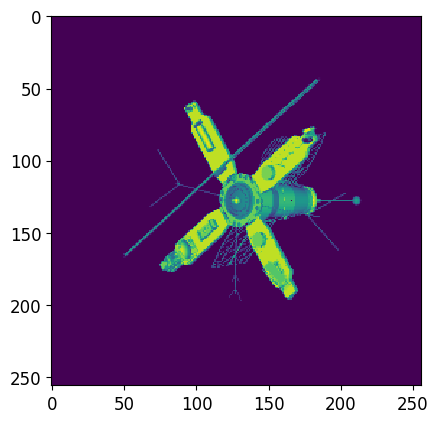

Dimensions of original image:  (256, 256)


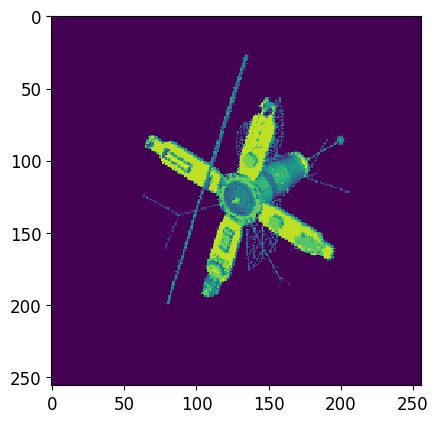

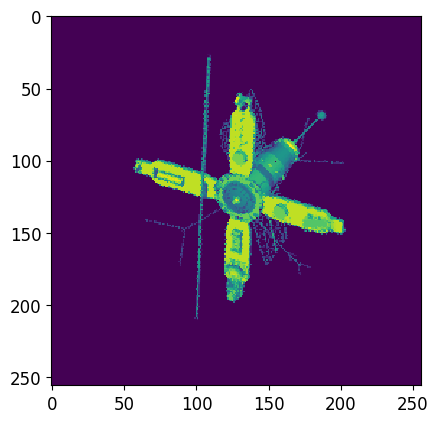

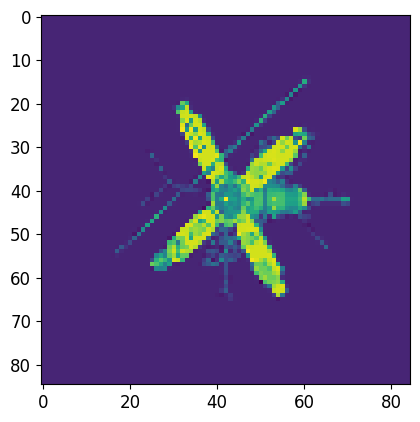

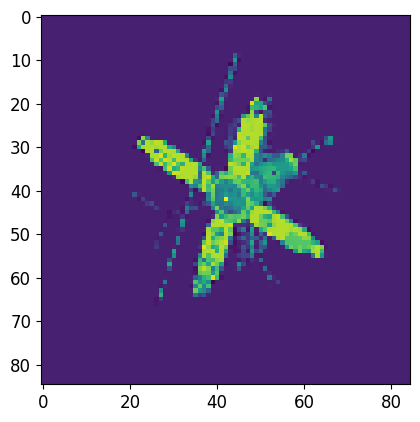

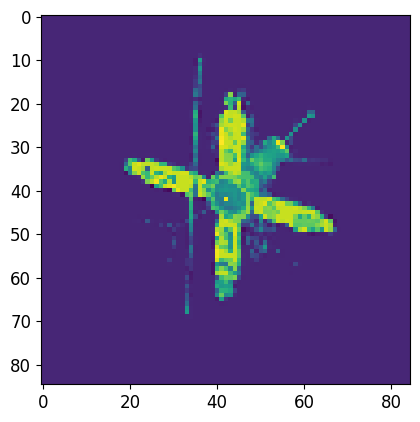

Dimensions of images:  (85, 85) (85, 85) (85, 85)
(7225, 3)
Norms:  [0.00443546 0.00445077 0.00442615]
Norms squared:  [1.96733476e-05 1.98093736e-05 1.95908279e-05]
Shapes:  (7225, 3)
New normalized norms:  [85. 85. 85.]
Fraction of non-zeros: [0.20788927 0.21148789 0.21148789]
Fraction of non-zeros in difference 0-1: 0.29633217993079586
Fraction of non-zeros in difference 1-2: 0.2956401384083045
covariance of B:  [[0.9997621  0.33956381 0.36476908]
 [0.33956381 0.99954462 0.48222599]
 [0.36476908 0.48222599 0.9995233 ]]


In [13]:
# Load the mat file
import numpy as np
data = np.loadtxt('real_data_experiment/sat_mat.mat')

# Plot the mat file
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

# Print original image dimensions
print("Dimensions of original image: ", data.shape)

# Create rotated version of the mat file as an image
from scipy import ndimage
rotated_1 = ndimage.rotate(data, 30, reshape=False, order = 0)
plt.imshow(rotated_1, interpolation='nearest')
plt.show()

from scipy import ndimage
rotated_2 = ndimage.rotate(data, 45, reshape=False, order = 0)
plt.imshow(rotated_2, interpolation='nearest')
plt.show()

# Downsample the images by a factor of 3
from scipy import ndimage
ds_factor = 3
data = ndimage.zoom(data, 1/ds_factor)
rotated_1 = ndimage.zoom(rotated_1, 1/ds_factor)
rotated_2 = ndimage.zoom(rotated_2, 1/ds_factor)
plt.imshow(data, interpolation='nearest')
plt.show()
plt.imshow(rotated_1, interpolation='nearest')
plt.show()
plt.imshow(rotated_2, interpolation='nearest')
plt.show()



# Print dimensions of both images
print("Dimensions of images: ", data.shape, rotated_1.shape, rotated_2.shape)
original_dimensions = data.shape

# Flatten all three images, and stack them into a single matrix
flat_data = data.flatten()
flat_rotated_1 = rotated_1.flatten()
flat_rotated_2 = rotated_2.flatten()
B = np.stack((flat_data, flat_rotated_1, flat_rotated_2), axis=1)
print(B.shape)

# Normalize the columns of B so that they have norm p and save the norms
from numpy.linalg import norm
norms = norm(B, axis=0)
print("Norms: ", norms)
print("Norms squared: ", norms**2)
B = (B / norms) * np.sqrt(B.shape[0])
print("Shapes: ", B.shape)
print("New normalized norms: ", norm(B, axis=0))

# Round all small entries to zero, just to see the sparsity level
B[B < 1e-10] = 0
print("Fraction of non-zeros:", np.count_nonzero(B, axis=0)/B.shape[0])

# Measure the sparsity of the difference between the original image and the rotated images
print("Fraction of non-zeros in difference 0-1:", np.count_nonzero(B[:,0]-B[:,1])/B.shape[0])
print("Fraction of non-zeros in difference 1-2:", np.count_nonzero(B[:,1]-B[:,2])/B.shape[0])

# Compute the covariance matrix of B
covariance = 1/B.shape[0] * B.T @ B
print("covariance of B: ", covariance)

### Run AMP

In [2]:
import numpy as np
import jax.numpy as jnp
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import GAMP_full, SE_fixed_C_v1
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from tqdm.auto import tqdm
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q

p = B.shape[0]
σ = 0.0001 # noise standard deviation
L = B.shape[1] # num signals. L-1 changepoints
α = 1/6 # α fraction is nonzero
st_ζ = 0.17 # 0.5 # soft thresholding threshold, set according to α (roughly 
# higher α, higher fraction of nonzeros, so set st_ζ lower to allow more nonzeros)
σ_l_arr = np.array([2.5, 2.5, 2.5]) # signal standard deviation

T = 10 # num_iterations
# δ_list = [0.5, 1.0]
δ_list = [0.25, 0.5, 0.75]
num_δ = len(δ_list)
num_trials = 1

seed = 29
nprandom.seed(2*seed)

# Soft thresholding denoiser
B̂_list = []
post_list = []
marginal_list = []
MAP_list = []
MAP_idx_list = []
corr_1 = []
corr_2 = []
hausdorff_list = []

possible_chgpt_configurations = [[0.3, 0.7]]

for i in range(len(δ_list)):
    δ = δ_list[i]
    print("--- δ: ", δ, " ---")

    n = int(δ * p)
    true_chgpt_locations = lambda n: (n * np.array(possible_chgpt_configurations[0])).astype(int)

    # Sparse Prior
    true_signal_prior = SparseGaussianSignal(α, δ, σ_l_arr)
    # true_signal_prior = GaussianSignal(np.eye(L))
    # est_signal_prior = SparseGaussianSignal(α* 1.5, δ, σ_l_arr) # α fraction is nonzero entries,
    # so estimate an upper bound on fraction of nonzeros
    # est_signal_prior = GaussianSignal(np.eye(L))
    print("True signal prior covariance: ", true_signal_prior.cov)
    ρ = (1/δ) * true_signal_prior.cov

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/4)
    Lmin = 1
    Lmax = 3 # TODO: ground truth is L=4 cell stages (3 chgpts).
    num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
    assert η_arr.shape == (num_valid_configs, Lmax-1) and \
        len(p_η_arr) == num_valid_configs
    assert ϕ.shape == (Lmax, n)

    print(f"True chgpts = {true_chgpt_locations(n)}")
    C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

    η_true = true_chgpt_locations(n)
  
    for i_trial in tqdm(range(num_trials)):

        B̃ = B
        # B̃ = true_signal_prior.sample(p)
        B̂_0 = true_signal_prior.sample(p)

        # Generate the observation vector Y
        X = nprandom.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        assert Θ.shape == (n, L)
        Y = changepoint_jax.q(Θ, C_true, σ).sample()

        #################### Soft thresholding denoiser ##########################
        # other than that, it is not used in the algorithm because ft is simple ST
        # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = \
        #     GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T = T, \
        #     true_signal_prior = true_signal_prior, \
        #         est_signal_prior = true_signal_prior, st_ζ = st_ζ, \
        #     verbose = False, seed = None, tqdm_disable = False)

        #################### Bayes optimal denoiser ##############################
        B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = \
            GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T = T, \
            true_signal_prior = true_signal_prior, \
                est_signal_prior = true_signal_prior, \
            verbose = False, seed = None, tqdm_disable = False)

        #################### Gaussian denoiser #####################################
        # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = \
        #     GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T = T, \
        #     true_signal_prior = true_signal_prior, \
        #         est_signal_prior = true_signal_prior, \
        #     verbose = False, seed = None, tqdm_disable = False)

        ################### Save the norm squared correlation ######################
        corr_1.append(norm_sq_corr(B̃[:, 0], B̂[:, 0]))
        corr_2.append(norm_sq_corr(B̃[:, 1], B̂[:, 1]))

        ##############################################################################
        B̂_list.append(B̂)
        # Compute the posterior distribution of C
        print("Computing posterior...")
        post = amp.posterior.posterior_over_η(η_arr, p_η_arr, Θ_t, Y, ρ, σ, ν_arr[-1], κ_T_arr[-1])
        max_idx = np.argmax(post)
        post_list.append(post)
        MAP_idx_list.append(max_idx)

        # Compute the marginal posterior
        print("Computing marginal posterior...")
        C_s = amp.posterior.η_arr_to_C_s(η_arr, n)
        marginal_list.append(amp.signal_configuration.marginal_prob_chgpt(C_s, post))

        # Compute Hausdorff distance
        hausdorff_list.append((1/n) * amp.performance_measures.hausdorff(η_arr[max_idx], η_true))
        

# Save the variables to a file
np.savez("satellite_2cp_d3_post.npz", δ_list=δ_list, B̂_list = B̂_list, corr_1 = corr_1, corr_2 = corr_2, post_list = np.array(post_list, dtype=object), MAP_idx_list = MAP_idx_list, marginal_list = np.array(marginal_list, dtype=object), hausdorff_list = hausdorff_list)

--- δ:  0.25  ---
True signal prior covariance:  [[1.04166667 0.         0.        ]
 [0.         1.04166667 0.        ]
 [0.         0.         1.04166667]]
True chgpts = [ 541 1264]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Computing posterior...
Computing marginal posterior...
--- δ:  0.5  ---
True signal prior covariance:  [[1.04166667 0.         0.        ]
 [0.         1.04166667 0.        ]
 [0.         0.         1.04166667]]
True chgpts = [1083 2528]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Computing posterior...
Computing marginal posterior...
--- δ:  0.75  ---
True signal prior covariance:  [[1.04166667 0.         0.        ]
 [0.         1.04166667 0.        ]
 [0.         0.         1.04166667]]
True chgpts = [1625 3792]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Computing posterior...
Computing marginal posterior...


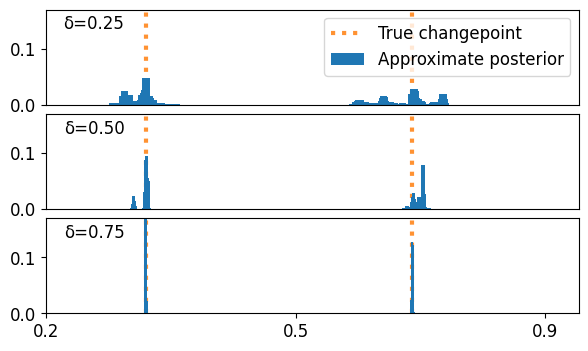

In [53]:
### Plot marginals
n_list = [int(δ * p) for δ in δ_list]
colors = ['C0', 'C1', 'C2']
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=3)
# plt.figure(figsize=(12,3)) # keynote slide size is 4:3
# for i in range(L-1): # iterate over number of changepoints
#     ax[0].axvline(x=true_chgpt_locations(n)[i], color="red",
#         alpha = 0.5, linestyle=':', label="True chgpt at "+ chgpt_loc_str_list[i])
    
for j in range(len(δ_list)):
    lower_xlim = 0.15
    upper_xlim = 0.95
    for i in range(L-1): # iterate over number of changepoints
        if i == 0:
            ax[j].axvline(x=true_chgpt_locations(n_list[j])[i], color=colors[1],
                alpha = 0.85, linestyle=':', label='True changepoint', linewidth=3, zorder=0)
        else:
            ax[j].axvline(x=true_chgpt_locations(n_list[j])[i], color=colors[1],
            alpha = 0.85, linestyle=':', linewidth=3, zorder=0)

    ax[j].bar(np.arange(0, marginal_list[j].shape[0]), marginal_list[j], label="Approximate posterior", color=colors[0], zorder = 1, width=20.0)
    ax[j].set_ylim([0, 0.17])
    # ax[j].set_yticks([])
    # ax[j].set_yticklabels([])
    ax[j].set_xticks([])


    if j == 0:
        # ax[j].set_ylabel("Posterior probability")
        # ax[j].set_yticks(np.arange(0, 0.11, 0.05))
        ax[j].legend()

    if j == len(δ_list)-1:
        # ax[j].set_xlabel(f"Fractional Changepoint Location")
        ax[j].set_xticks(np.round(np.arange(lower_xlim*n_list[j], upper_xlim*n_list[j], 0.375*n_list[j]), decimals = 1))
        ax[j].set_xticklabels(np.round(np.arange(lower_xlim, upper_xlim, 0.375), decimals=1))

        # for l in range(L-1):
        #     ax[j].set_xticks(true_chgpt_locations(n_list[j]), minor=True)
        #     ax[j].set_xticklabels(["η₁/n", "η₂/n"], minor=True)

    ax[j].set_xlim([lower_xlim*n_list[j], upper_xlim*n_list[j]])
    ax[j].text(0.09, 0.85, "δ=" + "{:.2f}".format(δ_list[j]), horizontalalignment='center', verticalalignment='center', transform=ax[j].transAxes)

# Prepare the figure for saving and displaying in latex
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.set_size_inches(6, 3.5)
fig.savefig("real_data_experiment/satellite_2cp_d3_post_noaxislabel.pdf", bbox_inches='tight')
plt.show()

    # ax[j].set_title(f'δ=n/p={δ}')
# plt.savefig(args.save_path + f'posterior_over_chgpt_locations_δ={δ}_i_δ={δ_idx}.pdf')

# ax[1].bar(np.arange(0, L), prob_num_chgpts, label="AMP average", color='orange')
# ax[1].scatter(np.arange(0, L), asymp_prob_num_chgpts, label="State evolution", 
#             color='green', alpha=0.5, marker='x')
# # ax[1].title(f"δ={δ}, p={p}, σ={σ}, T={T}, ntrials={num_trials}, L={L}, Δ=n*{Delta_str}, loc=n*{chgpt_loc_str_list}")
# ax[1].set_xticks(np.arange(L))
# ax[1].set_ylabel("Posterior probability")
# ax[1].set_xlabel("#chgpts")
# plt.savefig(args.save_path + f'posterior_over_num_chgpts_δ={δ}_i_δ={δ_idx}.pdf')
# fig.savefig(args.save_path + f'posterior_combined_δ={δ}_i_δ={δ_idx}.pdf', bbox_inches='tight')


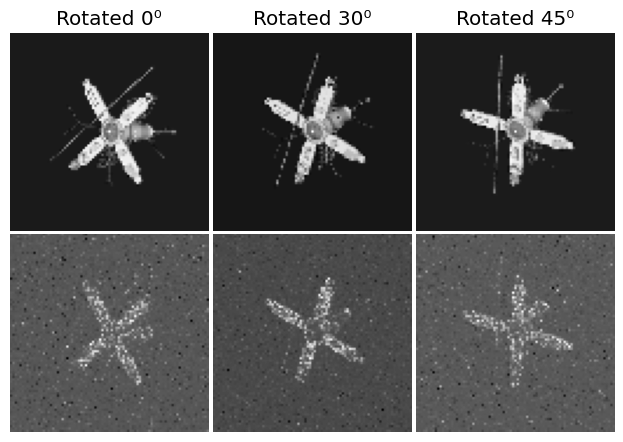

In [52]:
## Make a collage of all images
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Process the recoered image
rec1 = B̂_list[-1][:, 0].reshape(original_dimensions)
rec2 = B̂_list[-1][:, 1].reshape(original_dimensions)
rec3 = B̂_list[-1][:, 2].reshape(original_dimensions)

# Create a list of images
images = [data, rotated_1, rotated_2, rec1, rec2, rec3]
# Create a list of titles
titles = ["Rotated 0⁰", "Rotated 30⁰", "Rotated 45⁰", "", "", ""]
# Define the figure size
plt.rcParams.update({'font.size': 12})
fig_2 = plt.figure()
# Set a counter
i = 1
# loop over images and titles
for image, title in zip(images, titles):
    # Define subplot
    plt.subplot(2, 3, i)
    plt.subplots_adjust(hspace=0.00)
    # Plot the image
    plt.imshow(image, cmap='gray')
    # Set title
    if i <= 3:
        plt.title(title)
    # Set off the axis
    plt.axis('off')
    # Increment counter
    i += 1
# Set tight layout
plt.tight_layout()
fig_2.subplots_adjust(hspace=-0.160, wspace=0.025)
# Save the figure
plt.savefig('real_data_experiment/satellite_2cp_d3_reconstruction_replot.pdf')
# Show the figure
plt.show()


### Load saved experiment

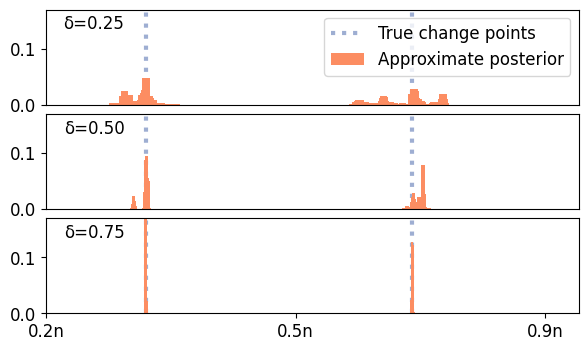

In [21]:
# Load the variables from the file
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
# rc('text', usetex=True)
# rc('font', family='serif')
# rc('font', size=12)
# rc('legend', fontsize=12)
# rc('legend', title_fontsize=12)
# rc('xtick', labelsize=12)
# rc('ytick', labelsize=12)
# rc('axes', labelsize=12)
# rc('axes', titlesize=12)

data = np.load("satellite_2cp_d3_post.npz", allow_pickle=True)
δ_list = data['δ_list']
B̂_list = data['B̂_list']
corr_1 = data['corr_1']
corr_2 = data['corr_2']
post_list = data['post_list']
MAP_idx_list = data['MAP_idx_list']
marginal_list = data['marginal_list']
p = 7225
L = 3
possible_chgpt_configurations = [[0.3, 0.7]]
true_chgpt_locations = lambda n: (n * np.array(possible_chgpt_configurations[0])).astype(int)

# Plot the marginal posterior over changepoint locations
### Plot marginals
n_list = [int(δ * p) for δ in δ_list]
colors = ['C0', 'C1', 'C2']
colors_dark = ['#1b9e77','#d95f02','#7570b3'] # darker
colors_light = ['#66c2a5','#fc8d62','#8da0cb'] # lighter
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=3)
# plt.figure(figsize=(12,3)) # keynote slide size is 4:3
# for i in range(L-1): # iterate over number of changepoints
#     ax[0].axvline(x=true_chgpt_locations(n)[i], color="red",
#         alpha = 0.5, linestyle=':', label="True chgpt at "+ chgpt_loc_str_list[i])
    
for j in range(len(δ_list)):
    lower_xlim = 0.15
    upper_xlim = 0.95
    for i in range(L-1): # iterate over number of changepoints
        if i == 0:
            ax[j].axvline(x=true_chgpt_locations(n_list[j])[i], color=colors_light[2],
                alpha = 0.85, linestyle=':', label='True change points', linewidth=3, zorder=0)
        else:
            ax[j].axvline(x=true_chgpt_locations(n_list[j])[i], color=colors_light[2],
            alpha = 0.85, linestyle=':', linewidth=3, zorder=0)

    ax[j].bar(np.arange(0, marginal_list[j].shape[0]), marginal_list[j], label="Approximate posterior", color=colors_light[1], zorder = 1, width=20.0)
    ax[j].set_ylim([0, 0.17])
    # ax[j].set_yticks([])
    # ax[j].set_yticklabels([])
    ax[j].set_xticks([])


    if j == 0:
        # ax[j].set_ylabel("Posterior probability")
        # ax[j].set_yticks(np.arange(0, 0.11, 0.05))
        ax[j].legend()

    if j == len(δ_list)-1:
        # ax[j].set_xlabel(f"Fractional Changepoint Location")
        ax[j].set_xticks(np.round(np.arange(lower_xlim*n_list[j], upper_xlim*n_list[j], 0.375*n_list[j]), decimals = 1))
        ax[j].set_xticklabels(np.round(np.arange(lower_xlim, upper_xlim, 0.375), decimals=1))
        ax[j].set_xticklabels(['0.2n', '0.5n', '0.9n'])
        # ax[j].set_xticklabels(["np.round(np.arange(lower_xlim, upper_xlim, 0.375), decimals=1)[i]" + "n" for i in range(3)])

        # for l in range(L-1):
        #     ax[j].set_xticks(true_chgpt_locations(n_list[j]), minor=True)
        #     ax[j].set_xticklabels(["η₁/n", "η₂/n"], minor=True)

    ax[j].set_xlim([lower_xlim*n_list[j], upper_xlim*n_list[j]])
    ax[j].text(0.09, 0.85, "δ=" + "{:.2f}".format(δ_list[j]), horizontalalignment='center', verticalalignment='center', transform=ax[j].transAxes)

# Prepare the figure for saving and displaying in latex
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.set_size_inches(6, 3.5)
fig.savefig("real_data_experiment/satellite_2cp_d3_post_noaxislabel_colorslight_n_withs.pdf", bbox_inches='tight')
plt.show()

    # ax[j].set_title(f'δ=n/p={δ}')
# plt.savefig(args.save_path + f'posterior_over_chgpt_locations_δ={δ}_i_δ={δ_idx}.pdf')

# ax[1].bar(np.arange(0, L), prob_num_chgpts, label="AMP average", color='orange')
# ax[1].scatter(np.arange(0, L), asymp_prob_num_chgpts, label="State evolution", 
#             color='green', alpha=0.5, marker='x')
# # ax[1].title(f"δ={δ}, p={p}, σ={σ}, T={T}, ntrials={num_trials}, L={L}, Δ=n*{Delta_str}, loc=n*{chgpt_loc_str_list}")
# ax[1].set_xticks(np.arange(L))
# ax[1].set_ylabel("Posterior probability")
# ax[1].set_xlabel("#chgpts")
# plt.savefig(args.save_path + f'posterior_over_num_chgpts_δ={δ}_i_δ={δ_idx}.pdf')
# fig.savefig(args.save_path + f'posterior_combined_δ={δ}_i_δ={δ_idx}.pdf', bbox_inches='tight')



### Comparison with DCDP

In [ ]:
import numpy as np
import jax.numpy as jnp
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import GAMP_full, SE_fixed_C_v1
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from tqdm.auto import tqdm
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q

p = B.shape[0]
n = int(0.75 * p)
σ = 0.0001 # noise standard deviation

possible_chgpt_configurations = [[0.3, 0.7]]
true_chgpt_locations = lambda n: (n * np.array(possible_chgpt_configurations[0])).astype(int)
C_true = η_to_ψ(np.array(true_chgpt_locations(n)), n)

B̃ = B
X = nprandom.normal(0, np.sqrt(1/n), (n, p))
Θ = X @ B̃
assert Θ.shape == (n, L)
Y = changepoint_jax.q(Θ, C_true, σ).sample()


#  Run DCDP
X_unit = np.sqrt(n) * X
Y_unit = np.sqrt(n) * Y
print("Running dcdp...")
dcdp_est = amp.comparison.DCDP(X_unit, Y_unit, λ_list = [5], γ_list = [500])